In [1]:
import sys
import os

relative_path = "/Users/james/Documents/Development/USAT-Designer/.Scripts"
abs_path = os.path.abspath(relative_path)

if abs_path not in sys.path:
    sys.path.insert(0, abs_path)

import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from universal_transcoder.plots_and_logs import *
from universal_transcoder.calculations.energy_intensity import *
from usat_designer.processing.constants import *
import usat_designer.utils.parameter_utils as pu
import warnings

In [2]:
def get_width_and_angular_error(cloud_points, S, output_layout):
    radial_i        = radial_I_calculation(cloud_points, S, output_layout)
    transverse_i    = transverse_I_calculation(cloud_points, S, output_layout)
    
    angular_error_calc  = angular_error(radial_i, transverse_i)
    width_calc          = width_angle(radial_i)

    return angular_error_calc, width_calc

In [3]:
def compute_q_s(angular_error, source_width):
    
    ae_mean     = np.mean(angular_error)            # mean angular error
    ae_90       = np.percentile(angular_error, 90)  # 90th percentile
    sw_median   = np.median(source_width)           # median source width

    hist_ae, bins_ae = np.histogram(angular_error, 
                                    bins=np.arange(0, 91, 5), 
                                    density=True)
    
    # Calculates the percentage of angles that have an angular error under 15° 
    cdf_ae      = np.cumsum(hist_ae) * np.diff(bins_ae)
    ae_under_15 = cdf_ae[np.searchsorted(bins_ae[1:], 15)]

    def normalize_inverse(x, min_val, max_val):
        return np.clip((max_val - x) / (max_val - min_val), 0, 1)

    score_ae_mean   = normalize_inverse(ae_mean, 0, 45)
    score_ae_90     = normalize_inverse(ae_90, 0, 90)
    score_under_15  = ae_under_15

    w_mean     = 0.4
    w_90       = 0.4
    w_under_15 = 0.2
    
    # median source width should be low --> include in quality metric
    # mean / standard deviation of the energy --> lower is better 
    # std of source width --> low, decoding is smooth, high --> point-like
    # Ambisonics book --> frank zotter

    q_s = (score_ae_mean * w_mean +
           score_ae_90   * w_90 +
           score_under_15 * w_under_15) * 100

    return q_s, sw_median   

In [4]:
def create_df_from_files(base_dir: str):
    entries = []

    outputs_dir = os.path.join(base_dir, "outputs")
    if not os.path.isdir(outputs_dir):
        raise ValueError(f"No outputs directory found at {outputs_dir}")
    
    # Get the 5OA_7_0_4 directory inside outputs
    subfolders = [f for f in os.listdir(outputs_dir) if os.path.isdir(os.path.join(outputs_dir, f))]
    if not subfolders:
        raise ValueError(f"No subfolders found inside outputs directory at {outputs_dir}")
    
    # Assuming there's only one subfolder here (like '5OA_7_0_4')
    second_level_dir = os.path.join(outputs_dir, subfolders[0])
    if not os.path.isdir(second_level_dir):
        raise ValueError(f"No directory found at second level: {second_level_dir}")

    # Now iterate inside second_level_dir for seed folders
    for folder_name in tqdm(os.listdir(second_level_dir)):
        
        folder_path = os.path.join(second_level_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        try:
            seed = int(folder_name.split("_")[-1])
        except ValueError:
            print(f"Skipping folder with invalid seed: {folder_name}")

        npz_path    = os.path.join(folder_path, f"matrix_data_{seed}.npz")
        json_path   = os.path.join(folder_path, f"metadata_{seed}.json")
        xml_path    = os.path.join(folder_path, f"y_parameters_{seed}.xml")

        with np.load(npz_path) as data:
            print(f"Keys in {npz_path}: {list(data.keys())}")
        
        with np.load(npz_path) as data:
            entry = {
                "seed": seed,
                "folder": folder_path,
                DSN_OUT_SPEAKER_MATRIX: data[DSN_OUT_SPEAKER_MATRIX],
                DSN_OUT_ENCODING_MATRIX: data[DSN_OUT_ENCODING_MATRIX],
                DSN_OUT_TRANSCODING_MATRIX: data[DSN_OUT_TRANSCODING_MATRIX],
                DSN_OUT_DECODING_MATRIX: data[DSN_OUT_DECODING_MATRIX],
            }

        if os.path.exists(xml_path):
            with open(xml_path, "r", encoding="utf-8") as f:
                xml_string  = f.read()
                parsed_xml  = pu.usat_xml_to_dict(xml_string)
                entry["y"]  = parsed_xml

        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                metadata    = json.load(f)
                coordinates = pu.restore_coordinates(metadata)
            entry.update(coordinates)

        ang_error, source_width = get_width_and_angular_error(entry[DSN_OUT_CLOUD], 
                                                              entry[DSN_OUT_SPEAKER_MATRIX], 
                                                              entry[DSN_OUT_OUTPUT_LAYOUT])
        q_s, median_sw = compute_q_s(ang_error, source_width)
        entry[DSN_SMPL_QUALITY_SCORE]            = round(q_s, 2)
        entry[DSN_SMPL_APPARENT_SOURCE_WIDTH]    = round(median_sw, 2)

        entries.append(entry)

    return pd.DataFrame(entries)


In [6]:
warnings.filterwarnings("ignore")
df = create_df_from_files("/Users/james/Documents/Development/USAT-Designer/.Scripts/usat_decodings_try")

y_expanded = df["y"].apply(pd.Series)
df = pd.concat([df.drop(columns=["y"]), y_expanded], axis=1)

enc_settings_exp = df[DSN_XML_SETTINGS].apply(pd.Series)
df = pd.concat([df.drop(columns=[DSN_XML_SETTINGS]), enc_settings_exp], axis=1)

ambi_order_in_exp = df[DSN_XML_INPUT_AMBISONICS].apply(pd.Series)
df = pd.concat([df.drop(columns=[DSN_XML_INPUT_AMBISONICS]), ambi_order_in_exp], axis=1)

ambi_order_out_exp = df[DSN_XML_OUTPUT_AMBISONICS].apply(pd.Series)
df = pd.concat([df.drop(columns=[DSN_XML_OUTPUT_AMBISONICS]), ambi_order_out_exp], axis=1)

output_layout_desc_exp = df[DSN_SMPL_OUTPUT_LAYOUT_DESC].apply(pd.Series)
df = pd.concat([df.drop(columns=[DSN_SMPL_OUTPUT_LAYOUT_DESC]), output_layout_desc_exp], axis=1)

coefficients_exp = df[DSN_XML_COEFFICIENTS].apply(pd.Series)
df = pd.concat([df.drop(columns=[DSN_XML_COEFFICIENTS]), coefficients_exp], axis=1)


columns_to_omit = [
    OPT_COEFF_PRESSURE,
    OPT_COEFF_RADIAL_VELOCITY,
    OPT_COEFF_TRANSVERSE_VELOCITY,
    OPT_COEFF_IN_PHASE_LINEAR,
    OPT_COEFF_SYMMETRY_LINEAR,
    OPT_COEFF_TOTAL_GAINS_LINEAR,
    OPT_COEFF_TOTAL_GAINS_QUADRATIC,
    DSN_XML_INPUT_SPEAKER_LAYOUT,
    DSN_XML_OUTPUT_SPEAKER_LAYOUT,
    DSN_OUT_OUTPUT_LAYOUT,
    DSN_OUT_CLOUD,
    DSN_OUT_SPEAKER_MATRIX,
    DSN_OUT_ENCODING_MATRIX,
    DSN_OUT_TRANSCODING_MATRIX,
    DSN_OUT_DECODING_MATRIX,
    ]

df_filtered = df.drop(columns=columns_to_omit)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Don't wrap output (optional but helpful)
df_filtered.head(10)


100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Keys in /Users/james/Documents/Development/USAT-Designer/.Scripts/usat_decodings_try/outputs/5OA_7_0_4/usat_3251097441/matrix_data_3251097441.npz: ['S', 'G', 'T_optimized', 'D']


,seed,folder,quality_score,median_source_width,InputLayoutDescription,InputType,OutputType,AmbisonicsOrderIn,AmbisonicsOrderOut,OutputLayoutDescription,energy,radial_intensity,transverse_intensity,in_phase_quad,symmetry_quad
0,3251097441,/Users/james/Documents/Development/USAT-Design...,67.14,29.860001,{'InputLayoutDescription': ''},Ambisonics,SpeakerLayout,5,1,layout_7_0_4,5.0,4.0,0.0,10.0,7.0


# Distribution of Quality Scores

### Highest Quality Scores

In [ ]:
# Show top 3 rows with highest quality scores
df_filtered.nlargest(3, QUALITY_SCORE)

### Lowest Quality Scores

In [ ]:
df_filtered.nsmallest(3, QUALITY_SCORE)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.histplot(df_filtered[QUALITY_SCORE], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Quality Scores")
plt.xlabel("Quality Score")
plt.ylabel("Occurances")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from USAT_Designer.launch_code.plots_usat_designer import *
from universal_transcoder.plots_and_logs.all_plots import *

df_head = df.iloc[13]

S               = df_head["S"]
cloud_plots     = df_head[CLOUD_POINTS]
output_layout   = df_head[OUTPUT_LAYOUT]
cloud_points    = df_head[CLOUD_POINTS]

energy = energy_calculation(S)

radial_intensity        = radial_I_calculation(cloud_plots, S, output_layout)
transverse_intensity    = transverse_I_calculation(cloud_plots, S, output_layout)
ae                      = angular_error(radial_intensity, transverse_intensity)
source_width            = width_angle(radial_intensity)

plots_general(output_layout,
              S,
              cloud_plots,
              True,
              False,
              "")


NameError: name 'df' is not defined

In [ ]:
import xml.etree.ElementTree as ET
from USAT_Designer.launch_code.receive_parameters import start_decoding

test_params = "704to5OA.xml"
tree        = ET.parse(test_params)
root        = tree.getroot()
xml_string  = ET.tostring(root, encoding='unicode')

dict = start_decoding(xml_string)

36


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


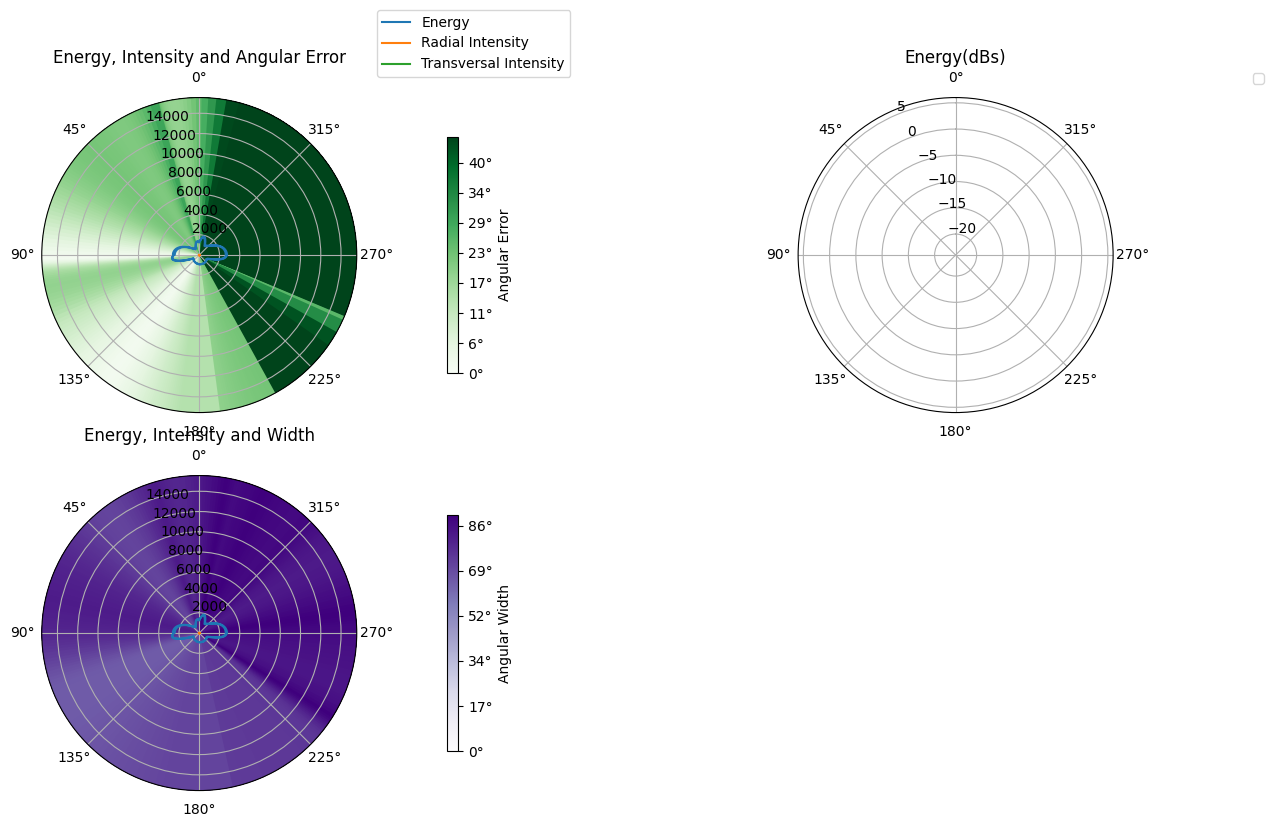

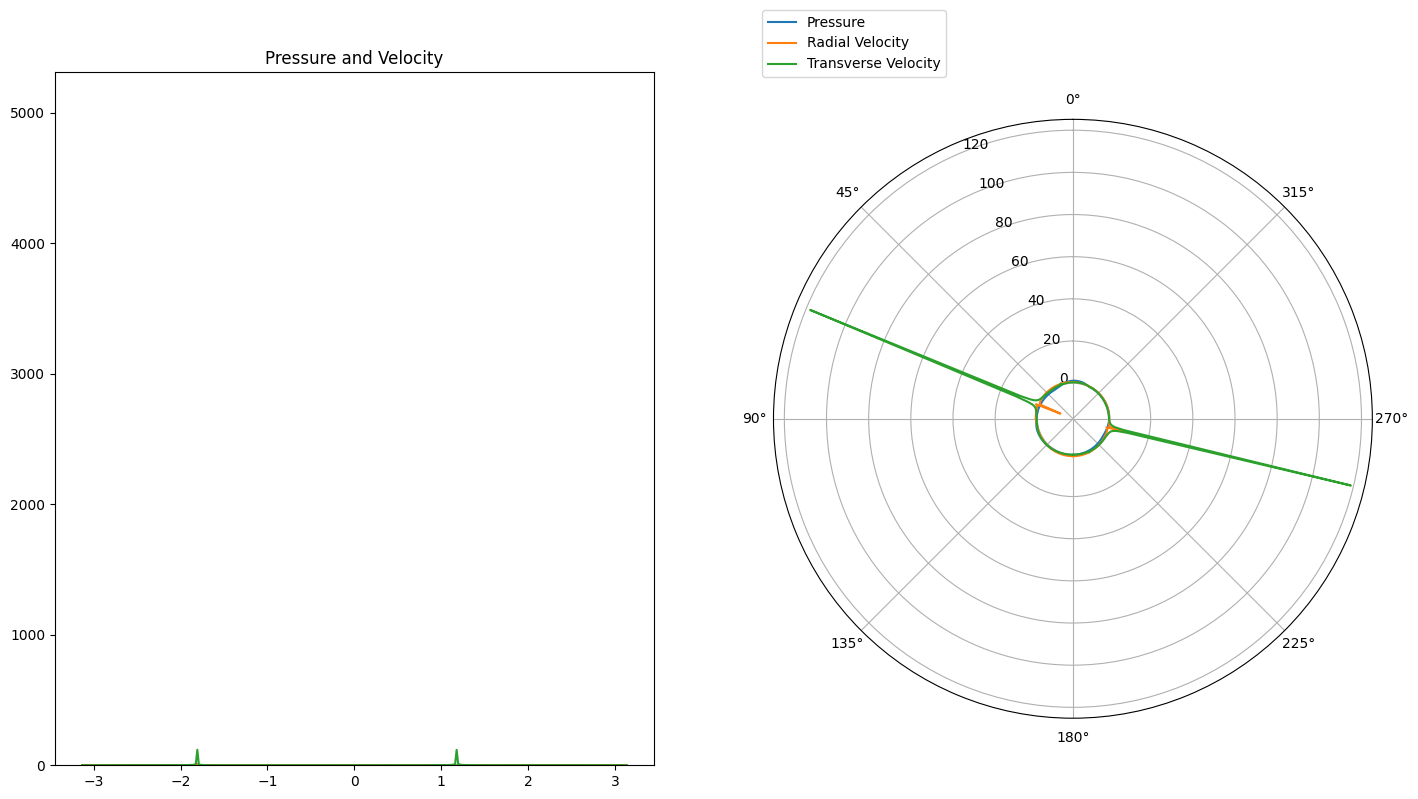

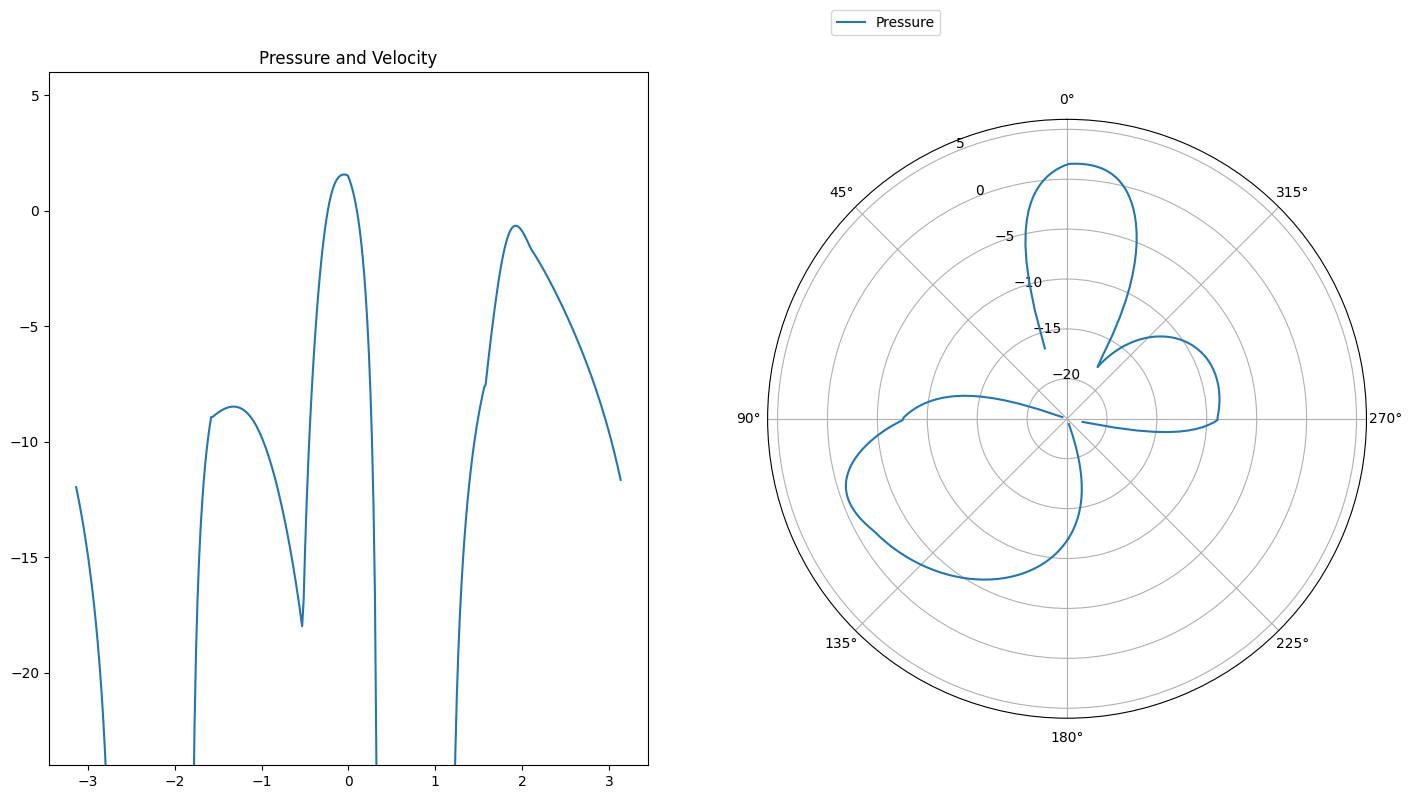

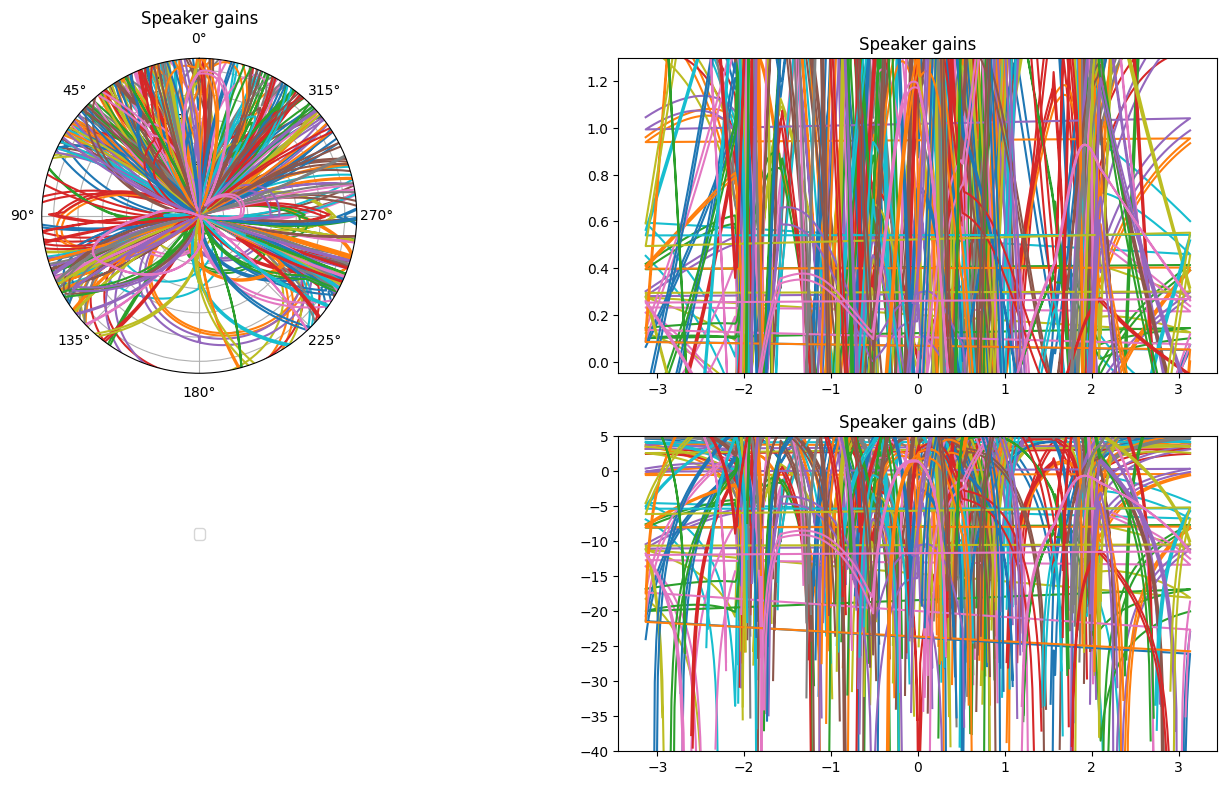

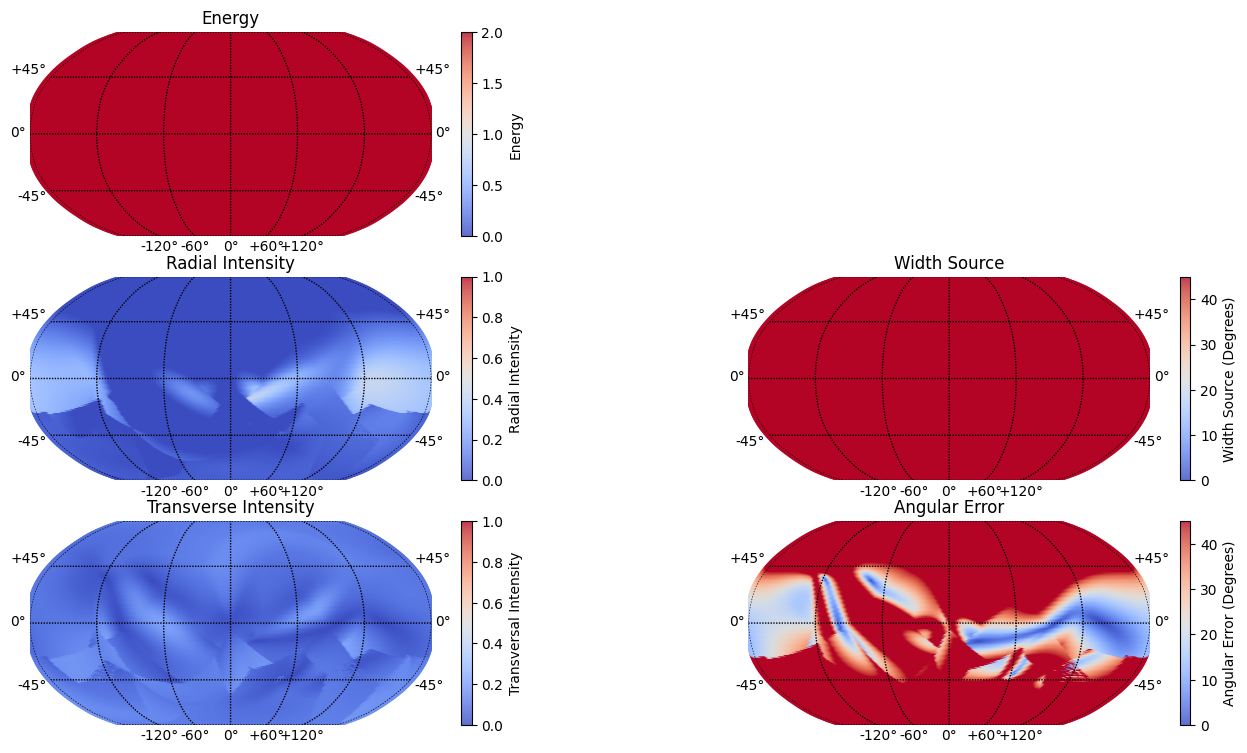

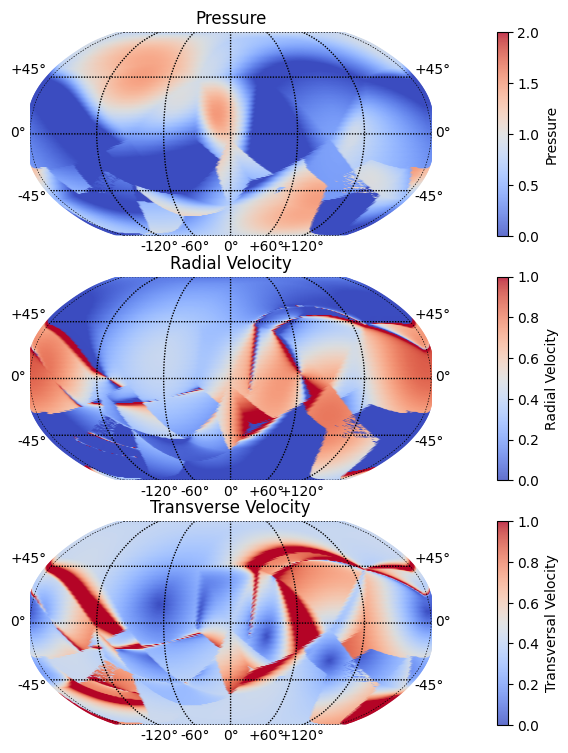

In [2]:
from universal_transcoder.calculations.energy_intensity import(
    energy_calculation,
    radial_I_calculation,
    transverse_I_calculation,
    angular_error,
    width_angle
)

from universal_transcoder.plots_and_logs.all_plots import plots_general

S               = all_matrices["S"]
cloud           = all_matrices["cloud"]
output_layout   = all_matrices["output_layout"]

energy = energy_calculation(S)

radial_intensity        = radial_I_calculation(cloud, S, output_layout)
transverse_intensity    = transverse_I_calculation(cloud, S, output_layout)
ae                      = angular_error(radial_intensity, transverse_intensity)
source_width            = width_angle(radial_intensity)

plots_general(output_layout,
              S,
              cloud,
              True,
              False,
              "")